# Downstream Evaluation: Microscopy Image Segmentation with MicroSAM

Microscopy image segmentation represents a challenging downstream task that serves as an excellent testbed for evaluating image restoration quality. This task is particularly valuable for restoration assessment because:

1. **Fine-scale Detail Preservation**: Microscopy images contain critical cellular structures and subcellular components that require precise boundary definition, making them highly sensitive to restoration artifacts
2. **Domain-specific Requirements**: Biological imaging has unique noise characteristics, contrast patterns, and structural features that differ significantly from natural images
3. **Clinical and Research Impact**: Accurate segmentation directly impacts medical diagnosis, drug discovery, and biological research applications
4. **Multi-modal Challenges**: Microscopy encompasses various imaging modalities (brightfield, fluorescence, phase contrast) each with distinct restoration requirements

This evaluation framework uses MicroSAM (Micro Segment Anything Model) to assess how well restored microscopy images maintain the critical structural information needed for accurate cellular segmentation.

## Setup and Dependencies

### MicroSAM Installation

This evaluation relies on the MicroSAM codebase for microscopy image segmentation. Follow these steps to set up the environment:

**Installation Steps:**
```bash
git clone https://github.com/computational-cell-analytics/micro-sam
cd micro-sam
git fetch
git checkout -b dev
conda env create -f environment.yaml
conda activate sam
pip install -e .
```

**Required Modification:**
You need to modify the training.py file to handle empty masks properly. In the file `micro_sam/training/training.py`, around line 495 in the `train_instance_segmentation` function, change:

```python
loss = torch_em.loss.DiceBasedDistanceLoss(mask_distances_in_bg=True)
```

to:

```python
loss = torch_em.loss.DistanceLoss(mask_distances_in_bg=True, foreground_loss=nn.MSELoss(reduction="mean"))
```

**Key Citations:**
- Archit, A., et al. (2023). "Segment Anything for Microscopy." bioRxiv preprint.
- MicroSAM Documentation: [https://computational-cell-analytics.github.io/micro-sam/](https://computational-cell-analytics.github.io/micro-sam/)

**Required Files:**
- Pre-trained SAM checkpoint (automatically downloaded)
- Microscopy dataset with ground truth segmentation masks
- Custom fine-tuned MicroSAM models (optional)

## Batch Evaluation Framework

This section provides comprehensive tools for running MicroSAM evaluation over batches of microscopy images, saving segmentation outputs, and computing detailed evaluation metrics including IoU, Dice scores, and boundary accuracy.

In [4]:
import torch
import os
print(torch.cuda.is_available())  # Returns True if a GPU is available

print(torch.cuda.current_device())  # Returns the current GPU device index
print(torch.cuda.device_count())    # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the first GPU (if available)

True
0
1
NVIDIA L40S


### Importing the libraries

In [5]:
import warnings
import os
warnings.filterwarnings("ignore")

from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler

# Fix micro_sam imports - use single level imports
import micro_sam.training as sam_training
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

In [20]:
# Verify torch_em and micro_sam are properly loaded
print("Checking torch_em availability...")
try:
    import torch_em
    print(f"torch_em version: {torch_em.__version__ if hasattr(torch_em, '__version__') else 'unknown'}")
    print(f"torch_em attributes: {[attr for attr in dir(torch_em) if not attr.startswith('_')]}")
    
    # Check for the specific function we need
    if hasattr(torch_em, 'default_segmentation_dataset'):
        print("✓ torch_em.default_segmentation_dataset is available")
    else:
        print("✗ torch_em.default_segmentation_dataset is NOT available")
        
    # Try alternative import paths
    try:
        from torch_em.segmentation import default_segmentation_dataset
        print("✓ Found default_segmentation_dataset in torch_em.segmentation")
    except ImportError:
        print("✗ default_segmentation_dataset not found in torch_em.segmentation")
        
except ImportError as e:
    print(f"Error importing torch_em: {e}")

print("\nChecking micro_sam availability...")
try:
    import micro_sam
    print(f"micro_sam loaded successfully")
    print(f"micro_sam training functions: {[attr for attr in dir(sam_training) if not attr.startswith('_')]}")
except ImportError as e:
    print(f"Error importing micro_sam: {e}")

Checking torch_em availability...
torch_em version: unknown
torch_em attributes: ['data', 'loss', 'model', 'segmentation', 'trainer', 'transform', 'util']
✗ torch_em.default_segmentation_dataset is NOT available
✓ Found default_segmentation_dataset in torch_em.segmentation

Checking micro_sam availability...
micro_sam loaded successfully
micro_sam training functions: ['CONFIGURATIONS', 'ConvertToSamInputs', 'JointSamLogger', 'JointSamTrainer', 'MedSAMTrainer', 'SamLogger', 'SamTrainer', 'SemanticMapsSamTrainer', 'SemanticSamTrainer', 'SimpleSamTrainer', 'default_sam_dataset', 'default_sam_loader', 'export_instance_segmentation_model', 'get_trainable_sam_model', 'identity', 'joint_sam_trainer', 'sam_trainer', 'semantic_sam_trainer', 'simple_sam_trainer', 'train_instance_segmentation', 'train_sam', 'train_sam_for_configuration', 'trainable_sam', 'training', 'util']


## Set paths

Below we set paths to our training data and the location we wish to put the trained model

## Updated for Local Usage

This notebook has been modified to work with local `gt` and `masks` directories instead of the original Windows paths. 

**Expected directory structure:**
```
current_directory/
├── gt/           # Ground truth images (any format: tif, png, jpg, etc.)
├── masks/        # Instance segmentation masks (uint16 format)
├── gt_8bit/      # Auto-generated 8-bit versions of gt images
└── models/       # Training outputs and exported models
```

The notebook will:
1. Automatically detect image formats in your directories
2. Convert images to 8-bit if needed
3. Set up training/validation splits based on available data
4. Save models and checkpoints locally

In [19]:
# Use local directories instead of Windows paths
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Set up paths for local gt and masks directories
segmentation_dir = os.path.join(current_dir, 'masks')  # Instance segmentation masks
image_dir = os.path.join(current_dir, 'gt')           # Ground truth images

# Create model output directory
model_path = os.path.join(current_dir, 'models')
os.makedirs(model_path, exist_ok=True)

print(f"Image directory: {image_dir}")
print(f"Segmentation directory: {segmentation_dir}")
print(f"Model path: {model_path}")

# Check if directories exist
if not os.path.exists(image_dir):
    print(f"Warning: Image directory {image_dir} does not exist!")
if not os.path.exists(segmentation_dir):
    print(f"Warning: Segmentation directory {segmentation_dir} does not exist!")

Current working directory: /data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs
Image directory: /data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs/gt
Segmentation directory: /data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs/masks
Model path: /data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs/models


## convert to 8 bit

For micro-sam inputs must be in 8 bit.  My training data generator outputs the images as normalized float bit so I convert to 8-bit in the cell below. 

(If you are using training data already in 8 bit format don't worry about his cell, but make sure you explicitly point ```image_dir_8bit``` to your training data)

In [20]:
# Convert images to 8-bit if needed
image_dir_8bit = os.path.join(current_dir, 'gt_8bit')

# Check what image files we have in the gt directory
gt_files = glob(os.path.join(image_dir, "*"))
print(f"Found {len(gt_files)} files in gt directory")
if gt_files:
    print("Sample files:", gt_files[:3])

# Create 8-bit images if they don't exist
if not os.path.exists(image_dir_8bit):
    os.makedirs(image_dir_8bit)
    print(f"Created 8-bit image directory: {image_dir_8bit}")
    
    # Get all image files (various formats)
    image_extensions = ['*.tif', '*.tiff', '*.png', '*.jpg', '*.jpeg']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob(os.path.join(image_dir, ext)))
    
    image_paths = sorted(image_paths)
    print(f"Found {len(image_paths)} image files to convert")
    
    for image_path in image_paths:
        try:
            image = imageio.imread(image_path)
            
            # Handle different image types
            if image.dtype == np.float32 or image.dtype == np.float64:
                # Assume normalized float images
                if image.max() <= 1.0:
                    image = (image * 255).astype('uint8')
                else:
                    image = image.astype('uint8')
            elif image.dtype == np.uint16:
                # Scale down from 16-bit to 8-bit
                image = (image / 256).astype('uint8')
            elif image.dtype == np.uint8:
                # Already 8-bit
                pass
            else:
                print(f"Unknown image dtype: {image.dtype} for {image_path}")
                continue
            
            # Save with same filename in 8-bit directory
            output_path = os.path.join(image_dir_8bit, os.path.basename(image_path))
            imageio.imwrite(output_path, image)
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    
    print(f"Converted images saved to: {image_dir_8bit}")
else:
    print(f"8-bit images already exist in: {image_dir_8bit}")

# Update image_dir to point to 8-bit images
image_dir = image_dir_8bit

Found 216 files in gt directory
Sample files: ['/data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs/gt/Cell_025_y0_x200.png', '/data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs/gt/Cell_022_y0_x0.png', '/data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs/gt/Cell_054_y0_x0.png']
8-bit images already exist in: /data/vision/beery/scratch/rupa/image-restoration/OneRestore/data_v3/cell_pairs/gt_8bit


### Let's create the dataloaders

Our task is to segment HeLa cells on a flat glass in DIC microscopic images. The dataset comes from https://celltrackingchallenge.net/2d-datasets/, and the dataloader has been implemented in [torch-em](https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/ctc.py).

#### First, let's visualize how our samples look.

image size is (200, 200)


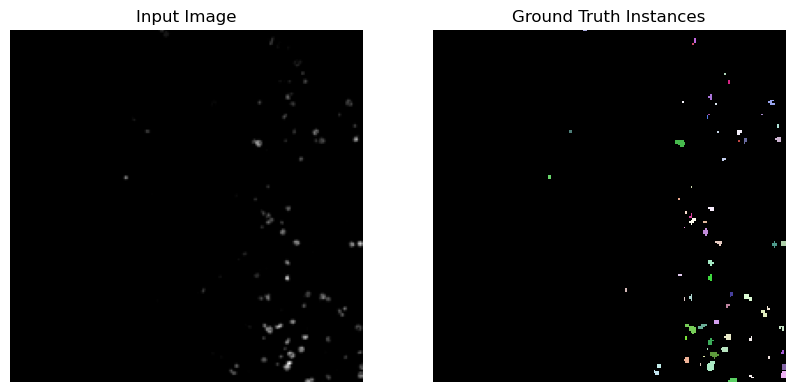

In [21]:
def random_label_cmap(n=2**16, h = (0,1), l = (.4,1), s =(.2,.8)):
    """
    Create a random colormap for labels
    
    Args:
        n (int, optional): number of labels. Defaults to 2**16.
        h (tuple, optional): hue range. Defaults to (0,1).
        l (tuple, optional): lightness range. Defaults to (.4,1).
        s (tuple, optional): saturation range. Defaults to (.2,.8).
        
        Returns:
        matplotlib.colors.ListedColormap: colormap for labels
    """
    import matplotlib
    import colorsys
    # cols = np.random.rand(n,3)
    # cols = np.random.uniform(0.1,1.0,(n,3))
    h,l,s = np.random.uniform(*h,n), np.random.uniform(*l,n), np.random.uniform(*s,n)
    cols = np.stack([colorsys.hls_to_rgb(_h,_l,_s) for _h,_l,_s in zip(h,l,s)],axis=0)
    cols[0] = 0
    return matplotlib.colors.ListedColormap(cols)

image_dir = image_dir_8bit
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    print('image size is', image.shape)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=random_label_cmap(), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")

    plt.show()
    plt.close()

    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders

In [6]:
# Update file patterns based on what we actually have
image_files = glob(os.path.join(image_dir, "*"))
mask_files = glob(os.path.join(segmentation_dir, "*"))

print(f"Image files: {len(image_files)}")
print(f"Mask files: {len(mask_files)}")

if image_files:
    image_ext = os.path.splitext(image_files[0])[1]
    print(f"Image extension: {image_ext}")
    raw_key = f"*{image_ext}"
else:
    raw_key = "*.tif"  # fallback

if mask_files:
    mask_ext = os.path.splitext(mask_files[0])[1]
    print(f"Mask extension: {mask_ext}")
    label_key = f"*{mask_ext}"
else:
    label_key = "*.tif"  # fallback

print(f"Using raw_key: {raw_key}, label_key: {label_key}")

# Adjust ROIs based on actual number of files
total_files = min(len(image_files), len(mask_files))
print(f"Total file pairs: {total_files}")

if total_files > 0:
    # Use 80% for training, 20% for validation
    train_split = int(0.8 * total_files)
    train_roi = np.s_[:train_split]
    val_roi = np.s_[train_split:]
    print(f"Training on {train_split} files, validation on {total_files - train_split} files")
else:
    # Fallback if no files found
    train_roi = np.s_[:, :, :]
    val_roi = np.s_[0:5, :, :]
    print("Warning: No files found, using default ROIs")

Image files: 216
Mask files: 216
Image extension: .png
Mask extension: .png
Using raw_key: *.png, label_key: *.png
Total file pairs: 216
Training on 172 files, validation on 44 files


## Create datasets

We create datasets mostly following the example ```microsam``` training code. 

We comment a few un-needed parts out.  For example we don't to use the ```MinInstanceSampler```, as in this case we want to use the images with empty masks so the model learns to ignore negative data. 

In [7]:
# The script below returns the train or val data loader for finetuning Segment Anything Model (SAM).
# The data loader must be a torch data loader that returns `x, y` tensors, where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `micro_sam.training.default_sam_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (256, 256)  # the size of patches for training

# NOTE: For this example we only want to train the instance segmentation decoder
train_instance_segmentation_only = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# The sampler below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
# BUT: this is not needed for the example data as WE WANT to train all images even ones with no instances.
# keep a look out for below line in other example code, as IF training on images with no instances is desired, then this line should be commented out.
#sampler = MinInstanceSampler(min_num_instances=0,min_size=0)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

train_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=True,
    train_instance_segmentation_only = True,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_train=True,
    rois=train_roi,
    #shuffle=True,
    #raw_transform=sam_training.identity,
    #sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=True,
    train_instance_segmentation_only = True,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_train=False,
    rois=val_roi,
    #shuffle=True,
    #raw_transform=sam_training.identity,
    #sampler=sampler,
)

### Run the actual model finetuning

**NOTE 1**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

**NOTE 2** Increase number of epochs for training in real scenarios.  

In [3]:
# All hyperparameters for training.
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 3  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

# Use local model directory
model_name = os.path.join(model_path, 'microsam_cell_segmentation')
os.makedirs(model_name, exist_ok=True)

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "cell_segmentation_checkpoints"

print(f"Device: {device}")
print(f"Model type: {model_type}")
print(f"Model save path: {model_name}")
print(f"Checkpoint name: {checkpoint_name}")

NameError: name 'torch' is not defined

In [14]:
# Run training 
sam_training.train_instance_segmentation(
    name=checkpoint_name,
    save_root=model_name, #os.path.join(root_dir, "models"),
    model_type=model_type,
    #checkpoint_path = checkpoint_previous_best_path,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,#n_epochs,#n_epochs,
    #lr = 1e-3,
    device=device,
)

Start fitting for 10500 iterations /  100 epochs
with 105 iterations per epoch
Training with mixed precision


Epoch 33: average [s/it]: 0.256189, current metric: 0.001346, best metric: 0.001021:  34%|███▍      | 3570/10500 [19:23<37:38,  3.07it/s]  

Stopping training because there has been no improvement for 10 epochs
Finished training after 33 epochs / 3570 iterations.
The best epoch is number 22.
Training took 1163.875916481018 seconds (= 00:19:24 hours)


## Export model

We need to export the model to the same format of the other microsam models

In [9]:
import os
model_name = "microsam_cell_segmentation"
checkpoint_name = "cell_segmentation_checkpoints"
model_path = "models"
# Export model paths
current_best_checkpoint = os.path.join(model_name, "checkpoints", checkpoint_name, "best.pt")
print(f"Best checkpoint path: {current_best_checkpoint}")

# Create export directory
export_dir = os.path.join(model_path, 'exported_models')
os.makedirs(export_dir, exist_ok=True)
exported_model_name = os.path.join(export_dir, "cell_segmentation_exported.pt")

print(f"Exported model path: {exported_model_name}")

# Check if checkpoint exists before exporting
if os.path.exists(current_best_checkpoint):
    print("Checkpoint found, exporting model...")
    sam_training.export_instance_segmentation_model(current_best_checkpoint, exported_model_name, model_type)
    print("Model exported successfully!")
else:
    print(f"Warning: Checkpoint not found at {current_best_checkpoint}")
    print("Please run training first before exporting the model.")

Best checkpoint path: microsam_cell_segmentation/checkpoints/cell_segmentation_checkpoints/best.pt
Exported model path: models/exported_models/cell_segmentation_exported.pt
Please run training first before exporting the model.


### Let's run the automatic instance segmentation (AIS)

In [10]:
def run_automatic_instance_segmentation(image, checkpoint_path, model_type="vit_b_lm", device=None, tile_shape = None, halo = None):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type, # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        is_tiled = (tile_shape is not None),  # whether the model is tiled or not.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,
        #ndim=2,
        tile_shape=tile_shape,
        halo=halo,
        foreground_threshold = 0.84
    )

    return prediction

**NOTE** When calling ```run_automatic_instance_segmentation``` we pass the ```exported_model_name```

Found 216 images and 216 segmentations
Will process 216 image pairs
Testing on 5 images

Processing image 1/5: Cell_001_y0_x0.png
Image shape: (200, 200), Segmentation shape: (200, 200)


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s]


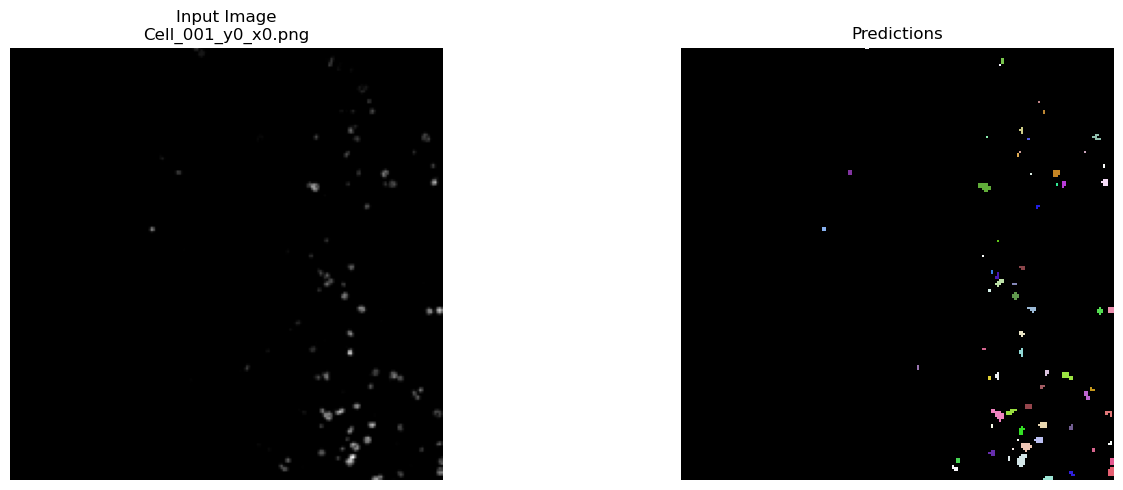


Processing image 2/5: Cell_001_y0_x200.png
Image shape: (200, 200), Segmentation shape: (200, 200)


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 25.59it/s]


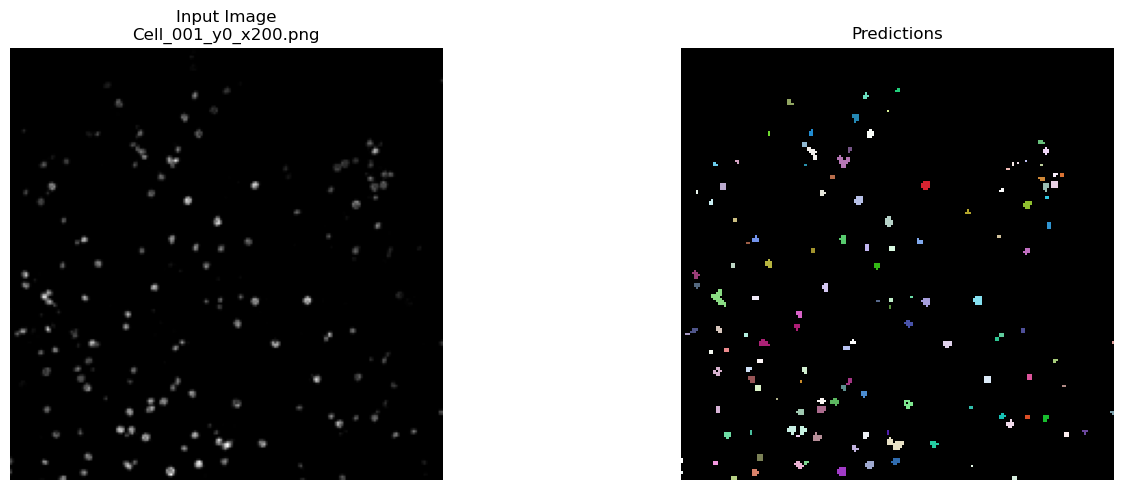


Processing image 3/5: Cell_001_y200_x0.png
Image shape: (200, 200), Segmentation shape: (200, 200)


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 25.61it/s]


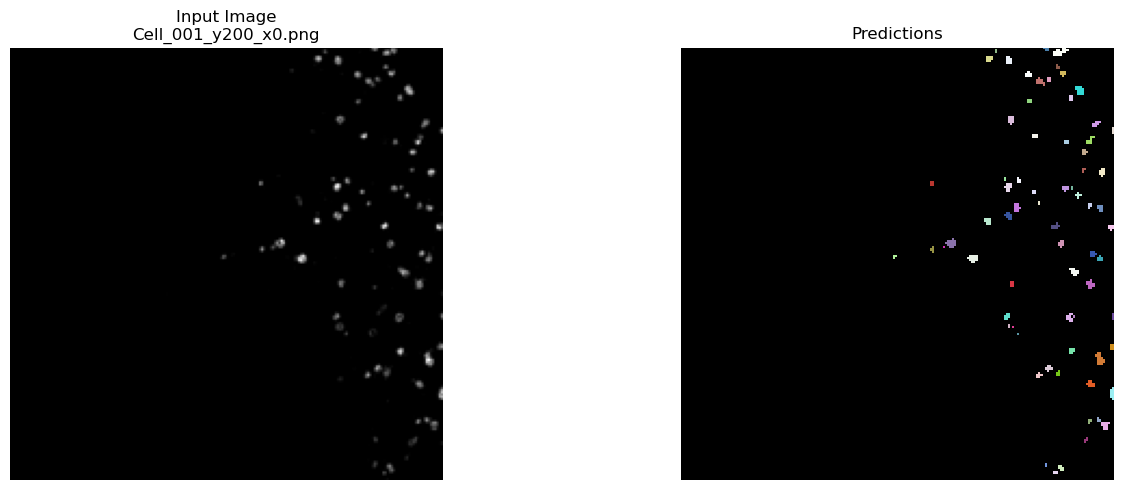


Processing image 4/5: Cell_001_y200_x200.png
Image shape: (200, 200), Segmentation shape: (200, 200)


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 24.95it/s]


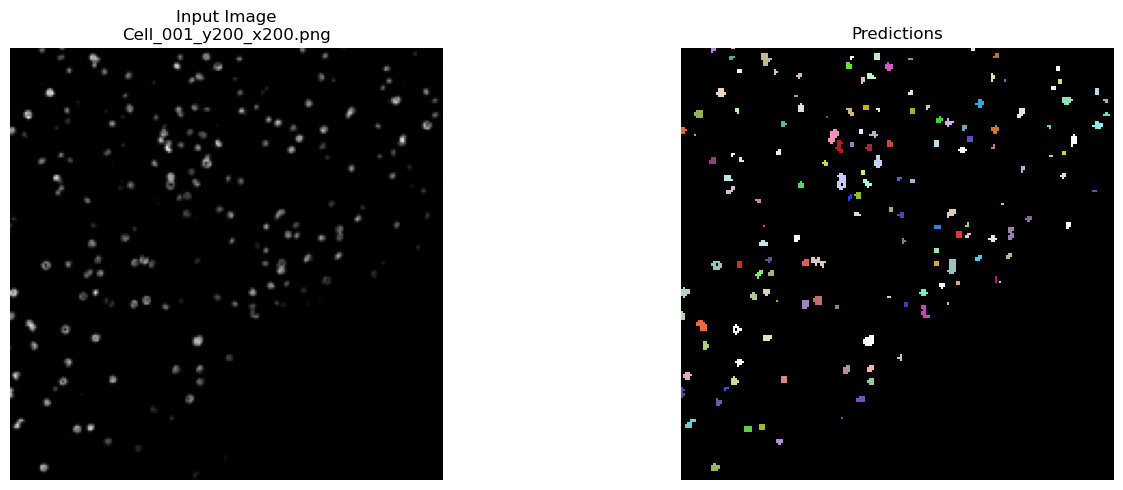


Processing image 5/5: Cell_002_y0_x0.png
Image shape: (200, 200), Segmentation shape: (200, 200)


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


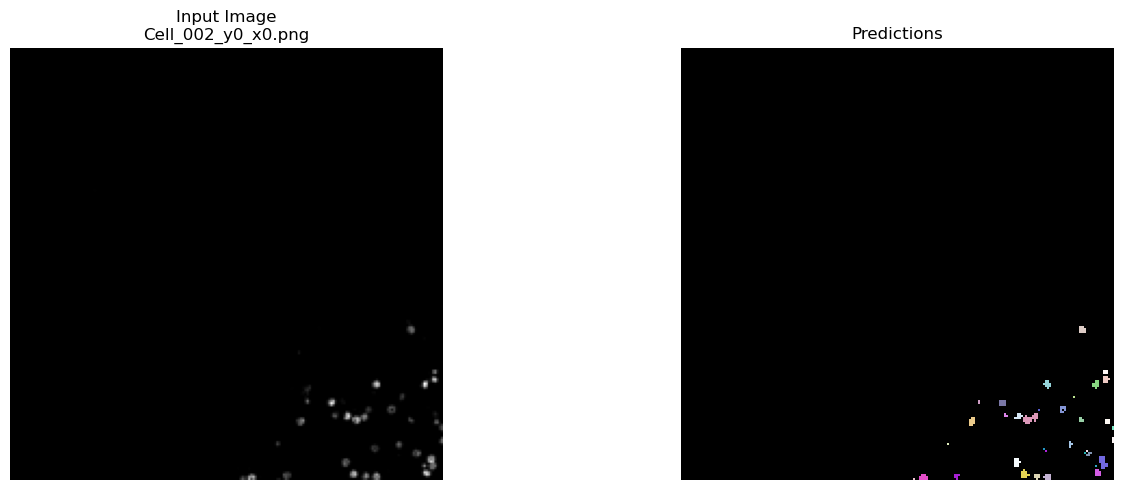

In [24]:
image_dir = "gt"
segmentation_dir = "masks"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
export_dir = os.path.join(model_path, 'exported_models')
# Get image and segmentation paths
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

print(f"Found {len(image_paths)} images and {len(segmentation_paths)} segmentations")

# Check if we have matching pairs
min_files = min(len(image_paths), len(segmentation_paths))
if min_files == 0:
    print("No matching image-segmentation pairs found!")
else:
    print(f"Will process {min_files} image pairs")
    
    # Take first few images for testing (adjust as needed)
    num_test_images = min(5, min_files)
    image_paths_ = image_paths[:num_test_images]
    segmentation_paths_ = segmentation_paths[:num_test_images]
    
    print(f"Testing on {len(image_paths_)} images")
    
    for i, (image_path, segmentation_path) in enumerate(zip(image_paths_, segmentation_paths_)):
        print(f"\nProcessing image {i+1}/{len(image_paths_)}: {os.path.basename(image_path)}")
        
        try:
            image = imageio.imread(image_path)
            segmentation = imageio.imread(segmentation_path)
            
            print(f"Image shape: {image.shape}, Segmentation shape: {segmentation.shape}")
            
            # Check if exported model exists before running inference
            if os.path.exists(exported_model_name):
                # Predicted instances
                prediction = run_automatic_instance_segmentation(
                    image=image, checkpoint_path=exported_model_name, model_type=model_type, device=device
                )
            else:
                print("Exported model not found, skipping prediction")
                prediction = np.zeros_like(segmentation)
            
            # Visualize the predictions
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))
            
            # Handle grayscale vs color images
            if len(image.shape) == 3:
                ax[0].imshow(image)
            else:
                ax[0].imshow(image, cmap="gray")
            ax[0].axis("off")
            ax[0].set_title(f"Input Image\n{os.path.basename(image_path)}")
            
            ax[1].imshow(segmentation, cmap=random_label_cmap(), interpolation="nearest")
            ax[1].axis("off")
            ax[1].set_title("Predictions")
            
            plt.tight_layout()
            plt.show()
            plt.close()
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

## Evaluation of Instance Segmentation

In this section, we quantitatively evaluate the performance of our trained instance segmentation model using the mean Intersection over Union (mIoU) metric. The mIoU measures the overlap between predicted instance masks and ground truth masks, providing a robust indicator of segmentation accuracy.

For each image, we compute the IoU for every ground truth instance against all predicted instances, selecting the best match. The final mIoU score is averaged over all images in the evaluation set. This allows us to assess how well the model distinguishes and segments individual cells.

The evaluation script automatically matches filenames between the ground truth (`gt`) and prediction (`predictions`) directories, computes mIoU for each pair, and reports both per-image and overall mean scores.

In [ ]:
from skimage.measure import label
import numpy as np
import os
from glob import glob

def compute_iou(gt_mask, pred_mask):
    """
    Compute IoU for each instance in the ground truth and prediction masks.
    Returns mean IoU (mIoU) over all matched instances.
    """
    gt_mask = label(gt_mask)
    pred_mask = label(pred_mask)
    gt_ids = np.unique(gt_mask)
    pred_ids = np.unique(pred_mask)
    gt_ids = gt_ids[gt_ids != 0]
    pred_ids = pred_ids[pred_ids != 0]

    ious = []
    for gt_id in gt_ids:
        gt_inst = gt_mask == gt_id
        best_iou = 0
        for pred_id in pred_ids:
            pred_inst = pred_mask == pred_id
            intersection = np.logical_and(gt_inst, pred_inst).sum()
            union = np.logical_or(gt_inst, pred_inst).sum()
            if union > 0:
                iou = intersection / union
                if iou > best_iou:
                    best_iou = iou
        ious.append(best_iou)
    if len(ious) == 0:
        return 0.0
    return np.mean(ious)

def batch_evaluate_miou(gt_dir, pred_dir, file_ext="png"):
    """
    Batch evaluation of mIoU for all image pairs in gt_dir and pred_dir.
    Assumes filenames are matched.
    """
    gt_files = sorted(glob(os.path.join(gt_dir, f"*.{file_ext}")))
    pred_files = sorted(glob(os.path.join(pred_dir, f"*.{file_ext}")))
    gt_names = [os.path.basename(f) for f in gt_files]
    pred_names = [os.path.basename(f) for f in pred_files]
    common_names = set(gt_names) & set(pred_names)
    miou_list = []
    for name in common_names:
        gt_mask = imageio.imread(os.path.join(gt_dir, name))
        pred_mask = imageio.imread(os.path.join(pred_dir, name))
        miou = compute_iou(gt_mask, pred_mask)
        miou_list.append(miou)
        print(f"{name}: mIoU={miou:.4f}")
    if miou_list:
        print(f"\nMean mIoU over {len(miou_list)} images: {np.mean(miou_list):.4f}")
    else:
        print("No matching files found for evaluation.")
    return miou_list

# Example usage:
batch_evaluate_miou(gt_dir="gt", pred_dir="predictions", file_ext="png")